# Dask Bag

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Map-Reduce"
* https://docs.dask.org/en/latest/bag.html
* Jesse C. Daniel. Data Science with Python and Dask. 
* https://docs.dask.org/en/stable/generated/dask.bag.read_text.html
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.distinct.html
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.count.html
* https://www.nltk.org/_modules/nltk/tokenize/regexp.html
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.mean.html
* https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.frequencies.html
* https://pypi.org/project/wordcloud/

## Задачи для совместного разбора

In [2]:
import dask.bag as db
import json

In [3]:
with open("posts.json") as fp:
    posts = json.load(fp)

1. Посчитайте длину (в кол-ве символов) каждого заголовка.

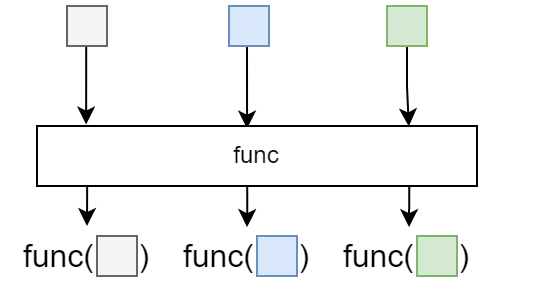

In [5]:
[len(p['title']) for p in posts][:5]

[74, 12, 59, 20, 18]

In [7]:
list(
    map(
        lambda p: len(p['title']),
        posts
    )
)[:5]

[74, 12, 59, 20, 18]

In [7]:
bag = db.from_sequence(posts, npartitions=8)
bag2 = bag.map(lambda p: len(p['title']))
print(bag2.compute()[:5])
print(bag2.take(5))

[74, 12, 59, 20, 18]
(74, 12, 59, 20, 18)


2. Выведите id постов, длина заголовков которых не более 15 символов.

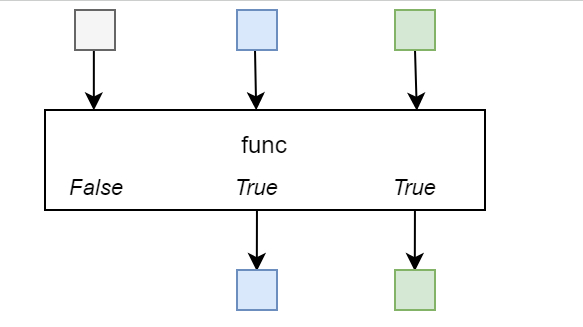

In [12]:
[p['id'] for p in posts if len(p['title'])<=15]

[2, 40, 41, 57, 91]

In [14]:
tuple(
    map(
        lambda p: p['id'],
        filter(
            lambda p: len(p['title'])<=15,
            posts
        )
    )
)

(2, 40, 41, 57, 91)

In [16]:
bag.filter(lambda p: len(p['title'])<=15).map(lambda p: p['id']).compute()

[2, 40, 41, 57, 91]

In [18]:
bag.filter(lambda p: len(p['title'])<=15).map(lambda p: p['id']).take(2, npartitions=-1)

(2, 40)

In [19]:
bag.filter(lambda p: len(p['title'])<=15).pluck('id').compute()

[2, 40, 41, 57, 91]

## Лабораторная работа 9

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

In [1]:
import dask.bag as db
import json

<p class="task" id="1"></p>

1\. В файлах архива `reviews_full.zip` находятся файлы, содержащие информацию об отзывах к рецептам в формате JSON Lines. Отзывы разделены на файлы в зависимости от оценки (например, в файле `reviews_1.json` находятся отзывы с оценкой 1). Считайте файлы из этого архива (предварительно разархивировав) в виде `dask.bag`. Преобразуйте текстовое содержимое файлов с помощью модуля `json`. Выведите на экран первые 5 элементов полученного `bag`.

Примечание: при необходимости вы можете разархивировать архив любым удобным способом.

In [2]:
rev_bag = db.read_text('reviews_full/reviews_*.json').map(json.loads)
rev_bag.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.'},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten'},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will be making this often.'},
 {'u

<p class="task" id="2"></p>

2\. Модифицируйте функцию разбора JSON таким образом, чтобы в каждый словарь c информацией об отзыве добавить ключ `rating`. Значение получите на основе названия файла (см. аргумент `include_path` функции `read_text`), использовав для этого регулярное выражение. При создании `bag` разбейте набор данных на сегменты размером 128 MiB (см. аргумент `blocksize`).  Выведите на экран первые 5 элементов полученного `bag` и количество сегментов в нем. 

In [143]:
import re
def parse_json(line):
    dic = json.loads(line[0])
    rating = re.search(r'reviews_full/reviews_(\d).json', line[1]).group(1)
    dic['rating'] = rating
    return dic

In [150]:
rev_bag2 = db.read_text(
    'reviews_full/reviews_*.json', blocksize='128MiB', include_path=True
).map(parse_json)
print(rev_bag2.take(5))
print(rev_bag2.npartitions)

({'user_id': 452355, 'recipe_id': 292657, 'date': '2016-05-08', 'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.', 'rating': '0'}, {'user_id': 329304, 'recipe_id': 433404, 'date': '2006-06-14', 'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten', 'rating': '0'}, {'user_id': 227932, 'recipe_id': 2008187, 'date': '1985-11-19', 'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will be making this ofte

<p class="task" id="3"></p>

3\. Посчитайте, сколько различных пользователей оставляли отзывы. Выведите это количество на экран.

In [4]:
rev_bag.map(lambda x: x['user_id']).distinct().count().compute()

226570

<p class="task" id="4"></p>

4\. Создайте версию `bag` из задания 2, в которой сохранены только отзывы, оставленные в 2014 и 2015 годах. Посчитайте и выведите на экран долю, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов.

In [173]:
bag4 = rev_bag2.filter(
    lambda x : x['date'].split('-')[0] in ('2014', '2015')
)

In [179]:
n_part = bag4.count().compute()

In [177]:
n = rev_bag2.count().compute()

In [178]:
n_part / n

0.08117811237929945

<p class="task" id="5"></p>

5\. Для отзывов, оставленных в мае 2013 года, выполните предобработку: 
   * приведите строки к нижнему регистру;
   * обрежьте пробельные символы в начале и конце строки;
   * удалите все символы, кроме английских букв и пробелов.
   
Посчитайте и выведите на экран среднюю длину этих отзывов после предобработки. Если текстовое содержимое отзыва отсутствует, считайте, что длина отзыва равна нулю.

In [28]:
import re
def remove_pun(line):
    text = line['review']
    text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
    line['review'] = text.lower().strip()
    return line

In [38]:
reviews_2013 = rev_bag.filter(
        lambda x : '2013-05' in x['date']
).map(remove_pun)

some = reviews_2013.map(
    lambda x : len(x['review'])
).sum().compute()
tog = reviews_2013.count().compute()
some / tog

268.90957913936364

<p class="task" id="6"></p>

6\. В файле `food.txt` представлен список из 329 ссылок на страницы Википедии, посвященные различным блюдам. Получив основное текстовое содержимое этих страниц, выясните, какие топ-30 слов используются в этих статьях чаще всего. Выведите на экран эти слова и их частоты.

Для разбиения текста на слова воспользуйтесь токенизатором `tokenizer`. В качестве препроцессинга приведите все слова к нижнему регистру и удалите стоп-слова, входящие в список английских стоп-слов из `nltk`.

При решении задачи не используйте параллельных вычислений. Измерьте время выполнения решения.

Примечание: под основным содержимым страницы подразумевается содержимое тега `div`, имеющего класс `mw-parser-output`.

In [14]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from bs4 import BeautifulSoup
import requests
import lxml

In [26]:
stopwords = stopwords.words('english')

In [30]:
%%time
st = ''
with open('food.txt') as f:
    for url in f.readlines():
        page = requests.get(url.replace('\n', ''))
        soup = BeautifulSoup(page.text, "lxml")
        st += soup.find_all(class_='mw-parser-output')[-1].text + ' '
        st = st.lower()
tokenizer = RegexpTokenizer(r'\w+')
all_words = tokenizer.tokenize(st)
nonstops = [word for word in all_words if word not in stopwords]
FreqDist(nonstops).most_common(30)

CPU times: total: 40.3 s
Wall time: 2min 24s


[('nasi', 8522),
 ('goreng', 4657),
 ('ayam', 4536),
 ('sate', 3414),
 ('pizza', 3301),
 ('mi', 3252),
 ('soto', 2769),
 ('rice', 2556),
 ('roti', 2546),
 ('indonesian', 2506),
 ('food', 2364),
 ('retrieved', 2344),
 ('edit', 2053),
 ('cheese', 1751),
 ('es', 1715),
 ('ikan', 1708),
 ('kari', 1708),
 ('babi', 1671),
 ('chicken', 1644),
 ('tahu', 1597),
 ('soup', 1573),
 ('rujak', 1530),
 ('dishes', 1483),
 ('bubur', 1427),
 ('list', 1407),
 ('also', 1377),
 ('teh', 1358),
 ('made', 1352),
 ('sayur', 1328),
 ('1', 1302)]

<p class="task" id="7"></p>

7\. Решите задачу 6, распараллелив процесс получения текста страницы из Википедии при помощи `dask.bag`.Выведите на экран полученный список топ-30 слов и их частоты. Для подсчета частот воспользуйтесь методом `Bag.frequencies`. Измерьте время выполнения решения.

Подсказка: обратите внимание на количество сегментов в `Bag`, который вы создали. 

In [54]:
def parmap(url):
    st = ''
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "lxml")
    st += soup.find_all(class_='mw-parser-output')[-1].text + ' '
    st = st.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    all_words = tokenizer.tokenize(st)
    nonstops = [word for word in all_words if word not in stopwords]
    return nonstops

In [56]:
%%time
bag = db.read_text('food.txt').map(lambda x: x.replace('\n', '')).repartition(100)
bag_w = bag.map(parmap).flatten()
bag_w.frequencies().topk(30, lambda x : x[1]).compute()

CPU times: total: 125 ms
Wall time: 26 s


[('nasi', 8522),
 ('goreng', 4657),
 ('ayam', 4536),
 ('sate', 3414),
 ('pizza', 3301),
 ('mi', 3252),
 ('soto', 2769),
 ('rice', 2556),
 ('roti', 2546),
 ('indonesian', 2506),
 ('food', 2364),
 ('retrieved', 2344),
 ('edit', 2053),
 ('cheese', 1751),
 ('es', 1715),
 ('ikan', 1708),
 ('kari', 1708),
 ('babi', 1671),
 ('chicken', 1644),
 ('tahu', 1597),
 ('soup', 1573),
 ('rujak', 1530),
 ('dishes', 1483),
 ('bubur', 1427),
 ('list', 1407),
 ('also', 1377),
 ('teh', 1358),
 ('made', 1352),
 ('sayur', 1328),
 ('1', 1302)]

<p class="task" id="8"></p>

8\. Визуализируйте результат, полученный в задаче 6 или 7, в виде облака слов. Для генерации облака слов вы можете воспользоваться пакетом [wordcloud](https://pypi.org/project/wordcloud/). Обратите внимание, что размер слова на визуализации должен зависеть от частоты использования этого слова.

In [63]:
from wordcloud import WordCloud
import dask_image
from dask_image.imread import imread
import dask.array as da
import matplotlib.pyplot as plt

In [85]:
import imageio
mk = imageio.imread("french.jpg")

w = WordCloud(width=800, height=600, mask=mk, background_color='white',
              contour_width=3, contour_color='firebrick').generate(' '.join(nonstops))
w.to_file('output.png')

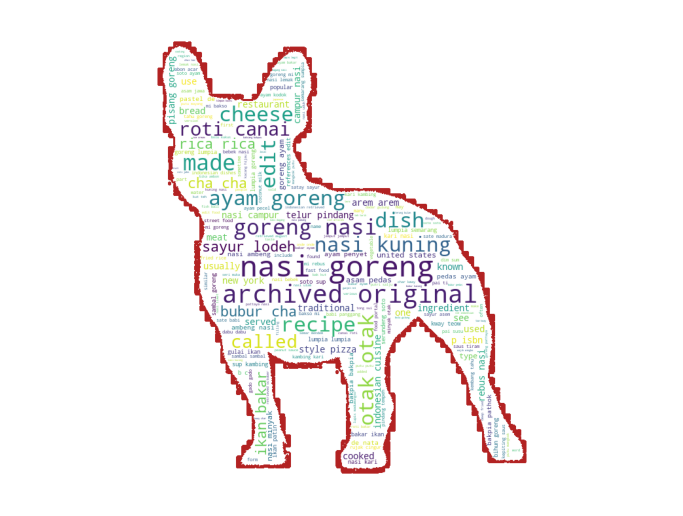

In [100]:
fig, axs = plt.subplots(figsize=(12,12))
axs.imshow(mk)
plt.axis("off");